# Shared and population-specific genetic variation

This analysis aimed to answer the following research question: **To what extent is genetic variation shared or unique within Central, Southern, Eastern and Western African populations?**

The following steps were completed:

1. Data Generation: Genetic variation data was generated from genetic information obtained from the [GnomAD 1000 Genomes and HGDP datasets](https://gnomad.broadinstitute.org/news/2021-10-gnomad-v3-1-2-minor-release/) for African population groups.
2. Data Preparation: The generated genetic variation data was processed and prepared for analysis following the steps detailed in the [Notebooks\Data_preparation\2-IH_allele_counts.ipynb](https://github.com/MeganHolborn/Genetic_data_analysis/blob/main/Notebooks/Data_preparation/2-IH_allele_counts.ipynb) Jupyter notebook. The resulting prepared data included variant positional information, allele counts, and frequencies, is stored [here](https://github.com/MeganHolborn/Genetic_data_analysis/blob/main/Data/Processed/IH_allele_counts.csv). Additionally, metadata on the individuals from which genetic variation data was generated, was prepared and stored [here](https://github.com/MeganHolborn/Genetic_data_analysis/blob/main/Data/Processed/Sample_populations.csv). 
3. Analysis and Visualisation: 
    * Genetic variant data was grouped based on geographic region (Central, Southern, Eastern and Western Africa). The variants unique to each region and shared between regions were then determined. 
    * To compare the shared and unique genetic variation among the different African regions, upset plots were used. Upset plots allow for visual comparison of overlapping or intersecting sets or categories. 


## Imports

Notebook setup

In [1]:
import os
import sys

from dotenv import load_dotenv

load_dotenv()

PROJECT_ROOT = os.getenv("PROJECT_ROOT")
if PROJECT_ROOT not in sys.path:
    os.chdir(PROJECT_ROOT + "/Notebooks")
    sys.path.append(PROJECT_ROOT)

import pandas as pd
import upsetplot
from matplotlib import pyplot as plt
import seaborn as sns
import Utils.constants as constants
import Utils.functions as functions

Import variant count data

In [2]:
ih_allele_counts = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "IH_allele_counts.csv",
    )
)

ih_allele_counts.head(5)

,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,IH_ALT_CTS,IH_TOTAL_CTS,ID,CORR_IH_TOTAL_CTS,CORR_IH_REF_CTS,REG,CORR_IH_AF,VARIANT_TYPE
0,rs552586867,110148891,C,G,COL4A1,NaN,2,350,110148891_G_C,1608.0,1606.0,Recent African,0.001244,SNP
1,rs552586867,110148891,C,G,COL4A1,Yoruba,2,350,110148891_G_C,392.0,390.0,NaN,0.005102,SNP
2,rs59409892,110148917,C,G,COL4A1,Yoruba,40,392,110148917_G_C,392.0,352.0,NaN,0.102041,SNP
3,rs59409892,110148917,C,G,COL4A1,Mende,18,196,110148917_G_C,196.0,178.0,WA,0.091837,SNP
4,rs59409892,110148917,C,G,COL4A1,Bantu South Africa,2,16,110148917_G_C,16.0,14.0,SA,0.125000,SNP


Import sample population data 

In [3]:
sample_subpopulations = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "Sample_populations.csv",
    )
)

sample_subpopulations.tail(5)

,SUB,SAMPLE_NAME,REG
799,Luhya,NA19475,EA
800,Mandenka,SS6004470,WA
801,Mbuti Pygmy,SS6004471,CA
802,San,SS6004473,SA
803,Yoruba,SS6004475,WA


## Data analysis and visualisation


### Data exploration

Are there any missing values in the variant count data?

In [4]:
ih_allele_counts.isnull().any()

VAR_NAME             False
POS                  False
REF                  False
ALT                  False
GENE                 False
SUB_POP               True
IH_ALT_CTS           False
IH_TOTAL_CTS         False
ID                   False
CORR_IH_TOTAL_CTS    False
CORR_IH_REF_CTS      False
REG                   True
CORR_IH_AF           False
VARIANT_TYPE         False
dtype: bool

The SUB_POP column contains missing data. This missing data is for rows that contain aggregated regional variant count data.

How many variants are there in total?

In [5]:
ih_allele_counts.ID.nunique()

9678

To get an understanding of how much unique genetic variation is contributed by each African population group to the analysis, I would like to visualise the number of unique variants as a function of the number of samples contributed by a population group.

In [6]:
# Group sample data by subpopulation

grouped_sample_subpopulations = (
    functions.group_and_count(sample_subpopulations, ["SUB"])
    .reset_index()
    .rename(columns={"SAMPLE_NAME": "SAMPLE_COUNT"})
    .drop(columns="REG")
)
grouped_sample_subpopulations["REG"] = grouped_sample_subpopulations["SUB"].map(
    constants.REGIONAL_CLASSIFICATION
)

In [7]:
# Order Eastern, Western, Southern and Central African subpopulations in order of smallest to largest population count.

subpopulation_order = grouped_sample_subpopulations.sort_values(
    by=["SAMPLE_COUNT", "REG"]
).SUB.tolist()

# Drop rows with NaN values in the SUB-POP column of the grouped_sample_subpopulations dataframe.

collated_af_ordered = ih_allele_counts.copy().dropna(subset="SUB_POP")

# Order subpopulations in ih allele counts dataframe.

collated_af_ordered.sort_values(
    by="SUB_POP",
    key=lambda column: column.map(lambda e: subpopulation_order.index(e)),
    inplace=True,
)

In [8]:
# Remove duplicated variants to avoid counting the same variant twice. We would like to see how the number of unique variants changes with the addition of sample populations, so need to avoid counting the same variant twice.

collated_af_unique = collated_af_ordered.drop_duplicates(subset=["ID"])

In [9]:
# Group by sub-population and count the cumulative number of variants

collated_af_subpop = (
    collated_af_unique.groupby(["SUB_POP"])
    .size()
    .reset_index()
    .rename(columns={0: "VARIANT_COUNT"})
)
collated_af_subpop.sort_values(
    by="SUB_POP",
    key=lambda column: column.map(lambda e: subpopulation_order.index(e)),
    inplace=True,
)
collated_af_subpop["CUMULATIVE_TOTAL_VARIANTS"] = collated_af_subpop[
    "VARIANT_COUNT"
].cumsum()

In [10]:
# Add sample count information to dataframe and count the cumulative number of samples

collated_af_subpop = (
    collated_af_subpop.merge(
        grouped_sample_subpopulations, left_on="SUB_POP", right_on="SUB"
    )
    .drop(columns=["SUB"])
    .set_index("SUB_POP")
)
collated_af_subpop["CUMULATIVE_SAMPLES"] = collated_af_subpop.sort_values(
    by=["VARIANT_COUNT", "REG"], ascending=True
)["SAMPLE_COUNT"].cumsum()
collated_af_subpop.head(5)

,VARIANT_COUNT,CUMULATIVE_TOTAL_VARIANTS,SAMPLE_COUNT,REG,CUMULATIVE_SAMPLES
SUB_POP,,,,,
San,2267,2267,6,SA,804
Bantu South Africa,949,3216,8,SA,701
Bantu Kenya,654,3870,12,EA,419
Mbuti Pygmy,613,4483,14,CA,407
Mandenka,517,5000,23,WA,23


Set plot parameters

In [11]:
sns.set(rc={"figure.figsize": (10, 8)})  # set plot size

plt.rc("font", size=constants.MEDIUM_FONT)  # controls default text sizes
plt.rc("axes", titlesize=constants.MEDIUM_FONT)  # fontsize of the axes title
plt.rc("axes", labelsize=constants.BIGGER_FONT)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("legend", fontsize=constants.MEDIUM_FONT)  # legend fontsize
plt.rc("figure", titlesize=constants.BIGGER_FONT)  # fontsize of the figure title

Create a plot showing the number of genetic variants as a function of sample size, while incrementally adding each subpopulation group to the analysis in a cumulative manner.

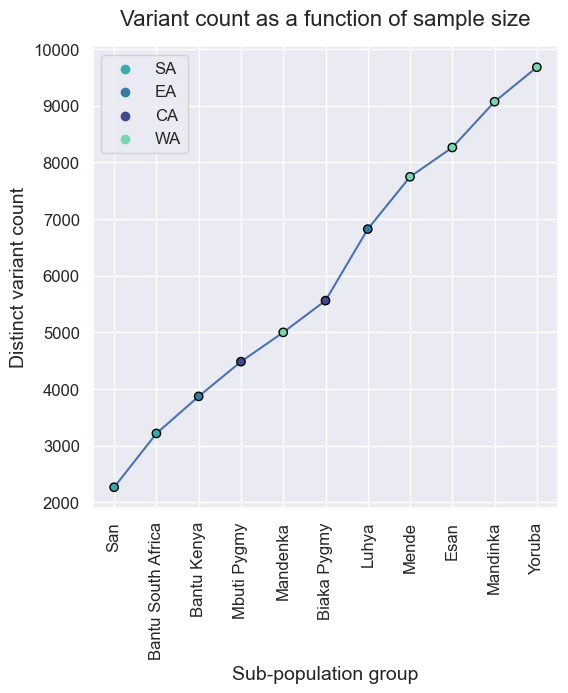

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))  # Set a custom size for this figure

# Assign the plot colouring

color_dict = dict({"SA": "#38AAAC", "EA": "#357BA3", "CA": "#40498E", "WA": "#79D6AE"})

# Create scatter plot

cum_variant_lineplot = sns.scatterplot(
    data=collated_af_subpop,
    x="SUB_POP",
    y="CUMULATIVE_TOTAL_VARIANTS",
    marker="o",
    hue="REG",
    palette=color_dict,
    edgecolor="black",
    linewidth=1,
    zorder=100,
)

# Create a line plot

cum_variant_lineplot = sns.lineplot(
    data=collated_af_subpop,
    x="SUB_POP",
    y="CUMULATIVE_TOTAL_VARIANTS",
    marker=None,
    zorder=1,
)

# Set x and y labels, title, and xtick rotation

cum_variant_lineplot.set(xlabel="Sub-population group", ylabel="Distinct variant count")
plt.xticks(rotation=90)
plt.title(
    "Variant count as a function of sample size",
    size=constants.LARGEST_FONT,
    pad=15,
    loc="center",
)

plt.savefig(
    "..\Results\Figures\Variant_discovery_curve.png", dpi=1200, bbox_inches="tight"
)
plt.show()

In the above figure, I incrementally added each subpopulation group to the analysis, to observe how much unique genetic variation each population group brings to the overall dataset. It was observed that the number of variants included in the analysis increases with each incremental addition of population group samples.

### Analysis to answer research question

Group data by variant and region

In [22]:
region_specific_allele_counts = ih_allele_counts.groupby(
    by=["VAR_NAME", "ID", "POS", "REF", "ALT", "VARIANT_TYPE", "GENE", "REG"]
).sum(numeric_only=True)

region_specific_allele_counts = (
    region_specific_allele_counts[~(region_specific_allele_counts.IH_ALT_CTS == 0)] # Remove rows with variants with alternate allele counts of 0. These variants are not present in the region.
    .drop(columns="CORR_IH_AF")
    .reset_index()
)

Drop rows with region set to Recent African

In [23]:
region_specific_allele_counts = region_specific_allele_counts[
    ~(
        (region_specific_allele_counts.REG == "Recent African") |
        (region_specific_allele_counts.REG == "African")
    )
]

Generate a dictionary with lists of variants for each region

In [24]:
region_variant_dict = {}
for region in region_specific_allele_counts.REG.unique():
    region_variants = region_specific_allele_counts[
        region_specific_allele_counts.REG == region
    ]["ID"].unique()
    region_variant_dict[region] = region_variants

Generate a set with the union of all variants across the lists

In [25]:
all_variants = set()
for value in region_variant_dict.values():
    all_variants.update(value)

Find overlap in variants for each region

In [26]:
variant_overlap = pd.DataFrame()

for region in region_specific_allele_counts.REG.unique():
    region_variant_overlap = pd.DataFrame(
        [[e in region_variant_dict[region]] for e in all_variants], columns=[region]
    )
    variant_overlap = pd.concat([variant_overlap, region_variant_overlap], axis=1)

Group variants by region

In [27]:
variant_overlap_grouped = variant_overlap.groupby(
    by=variant_overlap.columns.tolist()
).size()
variant_overlap_grouped.head(5)

EA     SA     WA     CA   
False  False  False  True      584
              True   False    2502
                     True      200
       True   False  False     349
                     True       75
dtype: int64

Plot overlap of variants for each African region

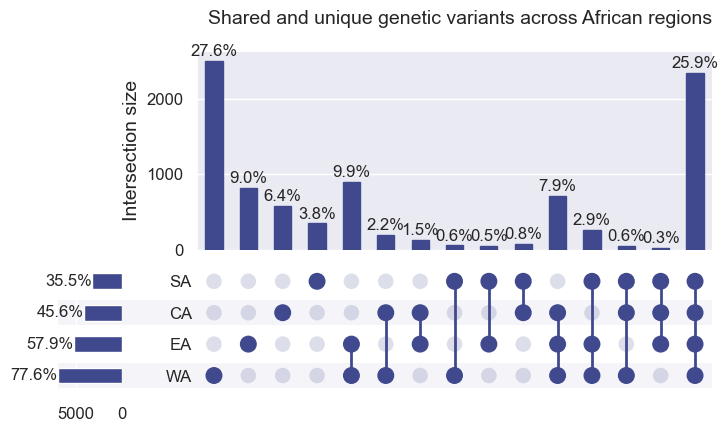

In [28]:
upsetplot.plot(
    variant_overlap_grouped,
    show_percentages=True,
    orientation="horizontal",
    facecolor="#40498E",
)
plt.title(
    "Shared and unique genetic variants across African regions",
    size=constants.BIGGER_FONT,
    pad=20,
    loc="right",
)
plt.savefig("..\Results\Figures\Shared_and_population_specific_variation.png", dpi=1200)
plt.show()

From the above plot, we observe that only 24.3% of genetic variants were shared by populations in Central, Southern, Eastern and Western Africa. This is indicative of the high genetic diversity in African populations.

Western African populations contributed the most  unique variants (32.1%) to the analysis, while Southern African populations contributed the least (3.5%). The data seems to indicate that there may be a correlation between the number of unique variants contributed by a region and the sample size of the region, since Western African populations made up the majority of the samples, and Southern African populations the least.


Calculate the degree of correlation between the number of samples comprising a regional group and the number of unique variants contributed by populations in the region. 

In [29]:
# Create a dataframe with unique variants contributed and the sample size for a region

unique_variant_regional_data = {
    "REG": ["WA", "EA", "CA", "SA"],
    "UNIQUE_VARIANT_PERCENT": [32.1, 8, 5.7, 3.5],
    "SAMPLE SIZE": [641, 109, 40, 14]
}

unique_variant_regional = pd.DataFrame(unique_variant_regional_data)

unique_variant_regional.head(5)

,REG,UNIQUE_VARIANT_PERCENT,SAMPLE SIZE
0,WA,32.1,641
1,EA,8.0,109
2,CA,5.7,40
3,SA,3.5,14


In [31]:
# Calculate the correlation 

unique_variant_regional.corr(numeric_only=True)

,UNIQUE_VARIANT_PERCENT,SAMPLE SIZE
UNIQUE_VARIANT_PERCENT,1.000000,0.999448
SAMPLE SIZE,0.999448,1.000000


There is a strong positive correlation (> 0.99) between the sample size of a region and the number of unique variants contributed by that region. As the majority of samples in this analysis are from Western Africa (80%), the genetic variants under examination are skewed towards Western African populations.